In [1]:
import os
import sys
import time
import copy

import numpy as np
import math
import random
import matplotlib.pyplot as plt

import functools
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import pickle

import datasets, models
import importlib
importlib.reload(models)
import init, measures
importlib.reload(init)

<module 'init' from '/Users/francesco/Projects/random-hierarchy-model/init.py'>

In [3]:
from dataclasses import dataclass
@dataclass
class config:

    device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

    dataset = 'rhm'
    mode = 'class'
    num_features = 16
    num_classes = 16
    num_synonyms = 4
    tuple_size = 2
    num_layers = 3
    seed_rules = 12345678
    num_tokens = 8 # context length, tuple_size**num_layers for the full input

    train_size = 2**20
    batch_size = 128
    accumulation = 1
    test_size = 2**15
    seed_sample = 12345678

#     input_format = 'long'
#     whitening = 0
    input_format = 'onehot'
    whitening = 1

    model = 'hcnn'
    depth = 3
    width = 512
    filter_size = 2
    bias = False
#     model = 'transformer_mla'
#     depth = 3
#     embedding_dim = 512
#     num_heads = 8
#     model = 'transformer_clm'
#     depth = 3
#     embedding_dim = 512
#     num_heads = 8
#     ffwd_size = 4
#     dropout = 0
    seed_model = 12345678

#     optim = 'adam'
#     lr = 1e-3
#     momentum = 0.0
#     scheduler = 'cosine-warmup'
#     warmup_time = 8
#     decay_time = 128
    optim = 'sgd'
    lr = 1.0
    momentum = 0.0
    scheduler = None
    max_epochs = 1

    print_freq = 32768
    save_freq = 2
    measure_train = False
    loss_threshold = 1e-3

config.num_data = config.num_classes*config.num_synonyms**((config.tuple_size**config.num_layers-1)//(config.tuple_size-1))
config.input_size = config.tuple_size**config.num_layers
config.num_batches = config.train_size//config.batch_size
config.max_iters = config.max_epochs*config.num_batches

print(f'{config.train_size} training data (total {config.num_data})')
print(config.device)

print(f"Training for {config.max_iters} steps")

1048576 training data (total 262144)
mps
Training for 8192 steps


In [4]:
# reinitialise dataset seeds for multiple runs
config.seed_rules = random.randint(10000000,99999999)
config.seed_sample = random.randint(10000000,99999999)
print(config.seed_rules, config.seed_sample)

33453487 51746424


## Initialise dataset

In [5]:
if config.dataset=='rhm':

    rhm = datasets.RHM(
        v=config.num_features,
        n=config.num_classes,
        m=config.num_synonyms,
        s=config.tuple_size,
        L=config.num_layers,
        seed_rules=config.seed_rules,
        seed_samples=config.seed_sample,
        num_data=config.train_size+config.test_size,
        probs=None,
        transform=None
    )
    inputs = rhm.trees[config.num_layers]
    targets = rhm.trees[0]

print(inputs.size())
print(targets.size())
train_loader, test_loader = init.init_data(inputs, targets, config)
# train_loader, test_loader = init.init_data(inputs, targets, config)
# for batch_idx, (x, y) in enumerate(train_loader):
#     print(x.size(), y.size())

torch.Size([1081344, 8])
torch.Size([1081344])


## Initialise Model

In [6]:
config.num_tokens = config.tuple_size**config.num_layers
config.model = 'hcnn'
config.depth = 3
config.width = 512
config.filter_size = 2
config.bias = False
# config.model = 'transformer_clm'
# config.depth = 3
# config.embedding_dim = 512
# config.num_heads = 8
# config.ffwd_size = 4
# config.dropout = 0
config.seed_model = random.randint(10000000,99999999)

model = init.init_model(config)
model0 = copy.deepcopy( model)

criterion, optimizer, scheduler = init.init_training( model, config)

# parameters: 1073152


## Train until convergence of the training loss

In [7]:
%%time
dynamics, best = init.init_output(model, criterion, train_loader, test_loader, config)
print(dynamics[0])

print_ckpts, save_ckpts = init.init_loglinckpt( config.print_freq, config.max_iters, freq=config.save_freq)
print_ckpt = next(print_ckpts)
save_ckpt = next(save_ckpts)

step = 0
config.outname = 'test'
print(config.outname)

{'t': 0, 'testloss': 2.7725790217518806, 'testacc': 0.061370849609375}
test
CPU times: user 192 ms, sys: 85.9 ms, total: 278 ms
Wall time: 1.15 s


In [8]:
for epoch in range(config.max_epochs):

    model.train()
    optimizer.zero_grad()
    running_loss = 0.

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        outputs = model(inputs.to(config.device))
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.to(config.device).view(-1))
        running_loss += loss.item()
        loss /= config.accumulation
        loss.backward()

        if ((batch_idx+1)%config.accumulation==0):
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            step += 1

            if step==print_ckpt:

                test_loss, test_acc = measures.test(model, criterion, test_loader, config.device)

                if test_loss<best['loss']: # update best model if loss is smaller
                    best['step'] = step
                    best['loss'] = test_loss
                    best['model'] = copy.deepcopy( model.state_dict())

                print('step : ',step, '\t running loss: {:06.4f}'.format(running_loss/(batch_idx+1)), ', test loss: {:06.4f}'.format(test_loss))
                print_ckpt = next(print_ckpts)

                if step>=save_ckpt:

                    print(f'Checkpoint at step {step}, saving data ...')
                    save_dict = {'t': step, 'testloss': test_loss, 'testacc': test_acc}
                    if config.measure_train:
                        train_loss, train_acc = measures.test(model, criterion, train_loader, config.device)
                        save_dict['trainloss'] = train_loss
                        save_dict['trainacc'] = train_acc
                    dynamics.append(save_dict)

                    output = {
                        'rules': rhm.rules,
                        'init': model0.state_dict(),
                        'best': best,
                        'model': copy.deepcopy(model.state_dict()),
                        'dynamics': dynamics,
                        'step': step
                    }
                    with open(config.outname, "wb") as handle:
                        pickle.dump(config, handle)
                        pickle.dump(output, handle)

                    save_ckpt = next(save_ckpts)


    if (running_loss/(batch_idx+1)) <= config.loss_threshold:

        save_dict = {'t': step, 'testloss': test_loss, 'testacc': test_acc}
        if config.measure_train:
            train_loss, train_acc = measures.test(model, criterion, train_loader, config.device)
            save_dict['trainloss'] = train_loss
            save_dict['trainacc'] = train_acc
        dynamics.append(save_dict)

        output = {
            'rules': rhm.rules,
            'init': model0.state_dict(),
            'best': best,
            'model': copy.deepcopy(model.state_dict()),
            'dynamics': dynamics,
            'step': step
        }
        with open(config.outname, "wb") as handle:
            pickle.dump(config, handle)
            pickle.dump(output, handle)

        break

step :  1 	 running loss: 2.7734 , test loss: 2.7726
Checkpoint at step 1, saving data ...
step :  2 	 running loss: 2.7731 , test loss: 2.7726
Checkpoint at step 2, saving data ...
step :  3 	 running loss: 2.7729 , test loss: 2.7725
Checkpoint at step 3, saving data ...
step :  4 	 running loss: 2.7727 , test loss: 2.7725
Checkpoint at step 4, saving data ...
step :  6 	 running loss: 2.7726 , test loss: 2.7725
Checkpoint at step 6, saving data ...
step :  8 	 running loss: 2.7726 , test loss: 2.7725
Checkpoint at step 8, saving data ...
step :  11 	 running loss: 2.7725 , test loss: 2.7725
Checkpoint at step 11, saving data ...
step :  16 	 running loss: 2.7725 , test loss: 2.7724
Checkpoint at step 16, saving data ...
step :  23 	 running loss: 2.7725 , test loss: 2.7723
Checkpoint at step 23, saving data ...
step :  32 	 running loss: 2.7725 , test loss: 2.7722
Checkpoint at step 32, saving data ...
step :  45 	 running loss: 2.7724 , test loss: 2.7720
Checkpoint at step 45, savin

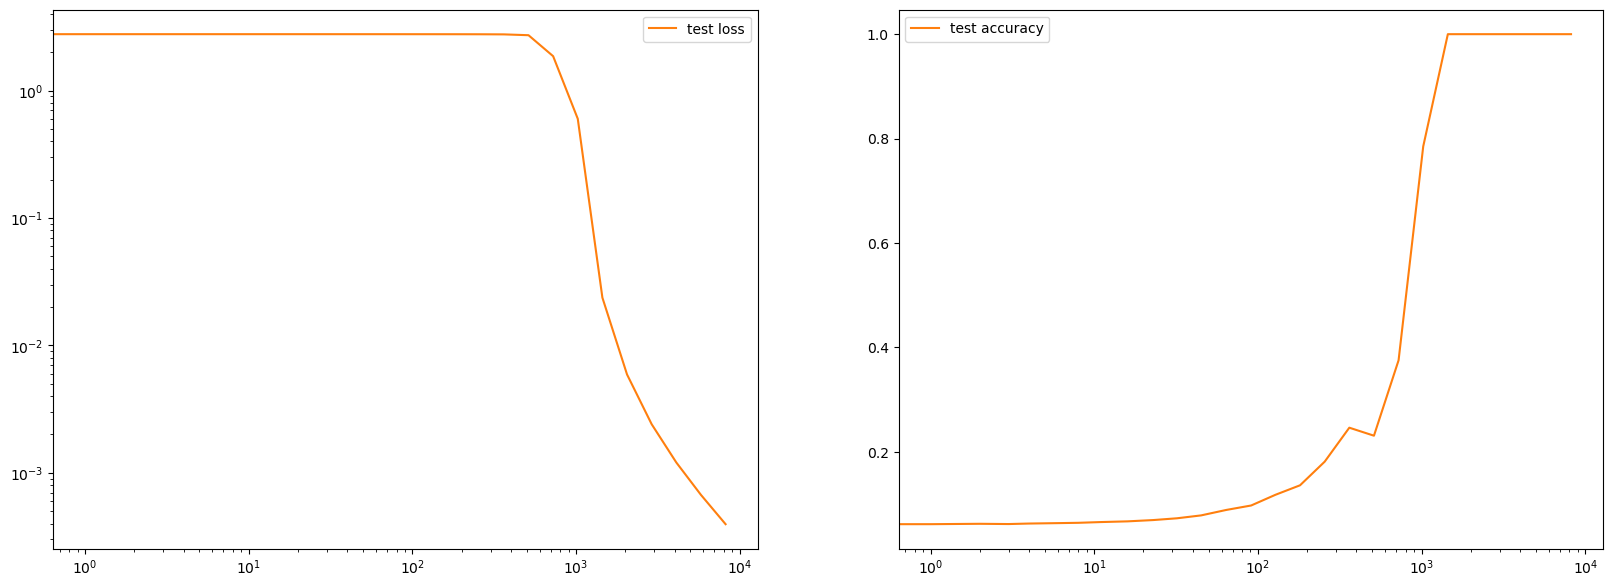

In [9]:
import math

fig, ax = plt.subplots(1, 2, figsize=(20,7))

ax[0].plot([d['t'] for d in dynamics], [d['testloss'] for d in dynamics], f'C1', label='test loss')
ax[1].plot([d['t'] for d in dynamics], [d['testacc'] for d in dynamics], f'C1', label='test accuracy')

if config.measure_train:
    ax[0].plot([d['t'] for d in dynamics], [d['trainloss'] for d in dynamics], f'C0', label='training loss')
    ax[1].plot([d['t'] for d in dynamics], [d['trainacc'] for d in dynamics], f'C0', label='training accuracy')


# ax[1].plot([d['t'] for d in dynamics], [d['displacement'][2][0] for d in dynamics], f'C2', label='2nd, left')
# ax[1].plot([d['t'] for d in dynamics], [d['displacement'][2][1] for d in dynamics], f'C3', label='2nd, right')


L = config.num_layers
v = config.num_features
m = config.num_synonyms
s = config.tuple_size


ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].legend()
ax[1].set_xscale('log')